# 10. Integrating Polars Into the Data Science Workflow

By this point in this course, we've gained a lot of dexterity with `polars`; now, it's time to use it in a real data science problem!

The problem we will be trying to solve is **tip amount prediction**, using the NYC taxi rides data that we've been using throughout this course. The goal here is to provide a service to taxi drivers which, before starting a taxi ride, they can plug the details of their ride into, and receive a prediction for what tip amount that customer can be expected to pay. They could then use this information to inform themselves on how to best interact with their passengers to increase their tip; furthermore, feature importance insights from such a model could help a taxi driver decide the best places in the city to work, or the best times in the week, etc.

We'll go through the entire data science process:
1. Setting Up the Environment
2. Loading Data
4. Brief Data Exploration
3. Cleaning and Preparing the Data
4. Feature Engineering and Selection
5. Model Building
6. Model Evaluation
7. Discussion

Let's get into it!

## 10.1. Setting up the Environment

Import `polars` as usual...

In [1]:
import polars as pl

But also import some other tools from the data science suite that we'll need throughout this notebook.

In [2]:
import matplotlib.pyplot as plt
# from lightgbm import LGBMRegressor

## 10.2. Loading Data

First, we load the data about zones:

In [4]:
zone_column_rename_mapping = {
    "LocationID": "location_id",
    "Borough": "borough",
    "Zone": "zone",
}
zones_df = (
    pl.read_parquet("../data/taxi_zone_lookup.parquet")
    .rename(zone_column_rename_mapping)
)

Then, we load in the yellow trips taxi data, for both february and march (using `*` file pattern notation), joining in the zone information as before:

In [5]:
yellow_rides_column_rename_mapping = {
    "VendorID": "vendor_id",
    "RatecodeID": "ratecode_id",
    "PULocationID": "pu_location_id",
    "DOLocationID": "do_location_id",
    "Airport_fee": "airport_fee",
}

zone_df_columns = ["borough", "zone", "service_zone",]

rides_df_raw = (
    pl.read_parquet("../data/yellow_tripdata_2024-*.parquet")
    .rename(yellow_rides_column_rename_mapping)
    .join(zones_df, left_on="pu_location_id", right_on="location_id")
    .rename({zone_df_column: f"pu_{zone_df_column}" for zone_df_column in zone_df_columns})
    .join(zones_df, left_on="do_location_id", right_on="location_id")
    .rename({zone_df_column: f"do_{zone_df_column}" for zone_df_column in zone_df_columns})
)

In [6]:
display(rides_df_raw.shape)
display(rides_df_raw.head())

(3582628, 25)

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
1,2024-03-01 00:18:51,2024-03-01 00:23:45,0,1.3,1,"""N""",142,239,1,8.6,3.5,0.5,2.7,0.0,1.0,16.3,2.5,0.0,"""Manhattan""","""Lincoln Square East""","""Yellow Zone""","""Manhattan""","""Upper West Side South""","""Yellow Zone"""
1,2024-03-01 00:26:00,2024-03-01 00:29:06,0,1.1,1,"""N""",238,24,1,7.2,3.5,0.5,3.0,0.0,1.0,15.2,2.5,0.0,"""Manhattan""","""Upper West Side North""","""Yellow Zone""","""Manhattan""","""Bloomingdale""","""Yellow Zone"""
2,2024-03-01 00:09:22,2024-03-01 00:15:24,1,0.86,1,"""N""",263,75,2,7.9,1.0,0.5,0.0,0.0,1.0,10.4,0.0,0.0,"""Manhattan""","""Yorkville West""","""Yellow Zone""","""Manhattan""","""East Harlem South""","""Boro Zone"""
2,2024-03-01 00:33:45,2024-03-01 00:39:34,1,0.82,1,"""N""",164,162,1,7.9,1.0,0.5,1.29,0.0,1.0,14.19,2.5,0.0,"""Manhattan""","""Midtown South""","""Yellow Zone""","""Manhattan""","""Midtown East""","""Yellow Zone"""
1,2024-03-01 00:05:43,2024-03-01 00:26:22,0,4.9,1,"""N""",263,7,2,25.4,3.5,0.5,0.0,0.0,1.0,30.4,2.5,0.0,"""Manhattan""","""Yorkville West""","""Yellow Zone""","""Queens""","""Astoria""","""Boro Zone"""


Looks good to go!

## 10.3. Brief Data Exploration

Before we proceed with any machine learning, let's first have a look at the data, viewed through the lens of the machine learning problem we're going to solve, keeping an eye out for anything we'll need to take care of during data cleaning and preparation:

In [7]:
rides_df_raw.describe()

statistic,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""",3.582628e6,"""3582628""","""3582628""",3.156438e6,3.582628e6,3.156438e6,"""3156438""",3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.582628e6,3.156438e6,3.156438e6,"""3582628""","""3582628""","""3582628""","""3582628""","""3582628""","""3582628"""
"""null_count""",0.0,"""0""","""0""",426190.0,0.0,426190.0,"""426190""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,426190.0,426190.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",1.758135,"""2024-03-16 13:36:21.144779""","""2024-03-16 13:53:01.505051""",1.337625,4.517412,2.255811,null,164.210534,163.156381,1.076212,18.682512,1.363928,0.482816,3.190803,0.541547,0.974287,27.12057,2.25238,0.142545,null,null,null,null,null,null
"""std""",0.431201,null,null,0.84003,302.411739,10.67769,null,64.470651,69.569802,0.64724,18.120599,1.808785,0.121177,4.032913,2.157286,0.223011,22.832365,0.837835,0.491772,null,null,null,null,null,null
"""min""",1.0,"""2002-12-31 22:17:10""","""2002-12-31 22:42:24""",0.0,0.0,1.0,"""N""",1.0,1.0,0.0,-800.0,-7.5,-0.5,-300.0,-84.3,-1.0,-800.99,-2.5,-1.75,"""Bronx""","""Allerton/Pelham Gardens""","""Airports""","""Bronx""","""Allerton/Pelham Gardens""","""Airports"""
"""25%""",2.0,"""2024-03-08 20:50:42""","""2024-03-08 21:05:46""",1.0,1.01,1.0,null,132.0,113.0,1.0,9.3,0.0,0.5,0.0,0.0,1.0,15.48,2.5,0.0,null,null,null,null,null,null
"""50%""",2.0,"""2024-03-16 10:54:00""","""2024-03-16 11:08:28""",1.0,1.75,1.0,null,161.0,162.0,1.0,13.5,1.0,0.5,2.52,0.0,1.0,20.52,2.5,0.0,null,null,null,null,null,null
"""75%""",2.0,"""2024-03-23 23:37:26""","""2024-03-23 23:52:31""",1.0,3.3,1.0,null,233.0,234.0,1.0,21.55,2.5,0.5,4.1,0.0,1.0,29.4,2.5,0.0,null,null,null,null,null,null
"""max""",6.0,"""2024-04-01 00:34:55""","""2024-04-02 18:08:46""",9.0,176836.3,99.0,"""Y""",265.0,265.0,4.0,900.0,14.25,35.84,999.99,163.0,1.0,1021.99,2.5,1.75,"""Unknown""","""Yorkville West""","""Yellow Zone""","""Unknown""","""Yorkville West""","""Yellow Zone"""


A few notes:
- Some rides had pickup and dropoff times that took place outside of the data's known time range of beginning of february 2024 until the end of march 2024 (for example the minimum `"tpep_pickup_datetime"` is `"2002-12-31 22:17:10"`.
- A few columns are missing data, all in exactly `611800` rows (about `10%` of the data): `"passenger_count"`, `"ratecode_id"`, `"store_and_fwd_flag"`, `"congestion_surcharge"`, and `"airport_fee"`.
- As we've seen throughout the course, some fields have impossibly subzero values, namely `"trip_distance"` and some of the currency columns (e.g. the mnimum `"fare_amount"` was `-$999`).

To the point that a few columns are missing data, let's double check the percentage of that:

In [8]:
rides_df_raw.select(pl.all().null_count() / pl.len())

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.11896,0.0,0.11896,0.11896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11896,0.11896,0.0,0.0,0.0,0.0,0.0,0.0


Since they are all the exact same number of missing rows, hopefully they are null together. Let's check:

In [9]:
cols_with_null = ["passenger_count", "ratecode_id", "store_and_fwd_flag", "congestion_surcharge", "airport_fee"]
rides_df_raw.select(
    pl.all_horizontal(pl.col(cols_with_null).is_null()).sum() / pl.len()
)

passenger_count
f64
0.11896


Indeed, they are all null together! We'll take care of this when it comes time to clean and prepare the data.

Next, let's plot an ECDF of the target variable. We can do this by passing a polars series directly to matplotlib:

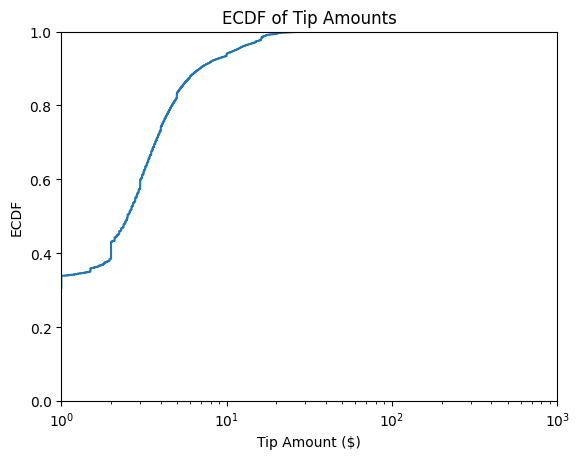

In [16]:
x = rides_df_raw["tip_amount"]
plt.ecdf(x)
plt.xlim(1, 1000)
plt.xscale("log")
plt.title("ECDF of Tip Amounts")
plt.xlabel("Tip Amount ($)")
plt.ylabel("ECDF")
plt.show()

Already we see some curious stuff in the target variable:
- `~35%` of rides had a `"tip_amount"` equal to zero.
- The next `~60%` of rides had a `"tip_amount"` between `$0` and `$10`.
- The remaining `~5%` of rides had a `"tip_amount"` of over `$10`.
- The target distribution function is nearly piecewise.

## 10.3. Cleaning and Preparing the Data

Over the course of this course, we've compiled some filters of impossible data, such as rides without passengers, and rides that had a pickup that occurred after the dropoff, and some of the other data issues we just discovered in the prior section (such as missing values). We'd like to handle this bad data before jumping into machine learning, so first let's quantify the scope of the issue:

In [11]:
remove_impossible_data_filter = (
    pl.col("tpep_pickup_datetime").lt(pl.col("tpep_dropoff_datetime")) &
    pl.col("passenger_count").gt(0)
)

In [12]:
rides_df_raw.select(remove_impossible_data_filter.mean().alias("fraction_data_usable"))

fraction_data_usable
f64
0.986883


Looks fine to remove!

While we're here, before we go

 However, we don't want to remove all the bad data just yet--**we only want to remove bad data from our train data**. This is because, when the model is performing live in the wild, we won't necessarily be guaranteed that the data will be clean in the way we'd like it to be; when taxi drivers use our system, perhaps they accidentally enter "0 passengers" 